Epoch 1/50, Loss: 0.00637
Epoch 2/50, Loss: 0.00206
Epoch 3/50, Loss: 0.00205
Epoch 4/50, Loss: 0.00203
Epoch 5/50, Loss: 0.00203
Epoch 6/50, Loss: 0.00203
Epoch 7/50, Loss: 0.00202
Epoch 8/50, Loss: 0.00203
Epoch 9/50, Loss: 0.00203
Epoch 10/50, Loss: 0.00202
Epoch 11/50, Loss: 0.00203
Epoch 12/50, Loss: 0.00202
Epoch 13/50, Loss: 0.00202
Epoch 14/50, Loss: 0.00203
Epoch 15/50, Loss: 0.00202
Epoch 16/50, Loss: 0.00203
Epoch 17/50, Loss: 0.00202
Epoch 18/50, Loss: 0.00202
Epoch 19/50, Loss: 0.00201
Epoch 20/50, Loss: 0.00201
Epoch 21/50, Loss: 0.00201
Epoch 22/50, Loss: 0.00201
Epoch 23/50, Loss: 0.00202
Epoch 24/50, Loss: 0.00202
Epoch 25/50, Loss: 0.00201
Epoch 26/50, Loss: 0.00201
Epoch 27/50, Loss: 0.00201
Epoch 28/50, Loss: 0.00201
Epoch 29/50, Loss: 0.00201
Epoch 30/50, Loss: 0.00201
Epoch 31/50, Loss: 0.00201
Epoch 32/50, Loss: 0.00201
Epoch 33/50, Loss: 0.00200
Epoch 34/50, Loss: 0.00201
Epoch 35/50, Loss: 0.00201
Epoch 36/50, Loss: 0.00200
Epoch 37/50, Loss: 0.00200
Epoch 38/5

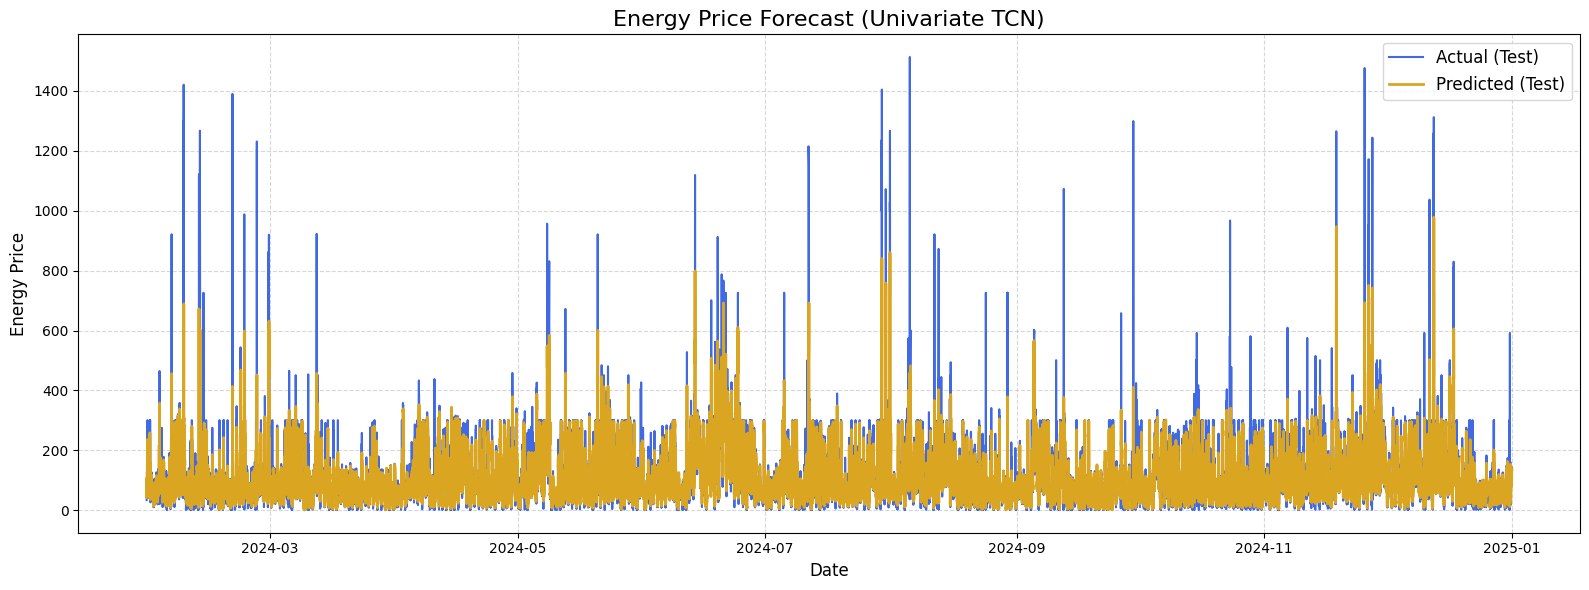


Evaluation Metrics:
Training Time (s) : 1988.37
Peak Memory (MB)  : 855.77
RMSE              : 36.4950
MSE               : 1331.8814
MAE               : 16.1285
MAPE (%)          : 26.96
R² Score          : 0.8067
Adj. R²           : 0.8067


In [23]:
# Energy Price Forecasting (Univariate)

# ─── Imports ─────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import time
import psutil
import os

# ─── Load Data ───────────────────────────────────────────────────────────────────
file_path = r"D:\Energy Price.csv"
df = pd.read_csv(file_path)

# ─── Preprocessing ───────────────────────────────────────────────────────────────
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M', errors='coerce')
df = df.dropna().sort_values('timestamp').reset_index(drop=True)
df = df[df['Energy_Price'] > 0].reset_index(drop=True)  # Assume already in log scale

# ─── Use Only Target (Univariate) ────────────────────────────────────────────────
target_col = 'Energy_Price'
scaler = MinMaxScaler()
df['Scaled'] = scaler.fit_transform(df[[target_col]])

# ─── Create Sequences ────────────────────────────────────────────────────────────
SEQ_LEN = 100
def create_sequences(series, seq_len):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i+seq_len])
        y.append(series[i+seq_len])
    return np.array(X), np.array(y)

X_np, y_np = create_sequences(df['Scaled'].values, SEQ_LEN)
X = torch.tensor(X_np, dtype=torch.float32).unsqueeze(1)  # (B, C=1, T)
y = torch.tensor(y_np, dtype=torch.float32)

# ─── Train-Test Split ────────────────────────────────────────────────────────────
split_idx = int(0.7 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# ─── Define TCN Components ───────────────────────────────────────────────────────
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU()
        )
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=3):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            in_ch = input_size if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            dilation = 2 ** i
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation))
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size)
    def forward(self, x):
        y = self.network(x)
        return self.linear(y[:, :, -1])

# ─── Training ────────────────────────────────────────────────────────────────────
def get_memory_usage():
    return psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)

device = torch.device("cpu")
model = TCN(1, 1, [16, 32, 32, 32]).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 50
BATCH_SIZE = 512
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)

start_time = time.time()
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb).squeeze()
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.5f}")

train_time = round(time.time() - start_time, 2)
peak_mem = round(get_memory_usage(), 2)

# ─── Prediction ──────────────────────────────────────────────────────────────────
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).cpu().numpy().squeeze()

# ─── Inverse Scaling and Log Correction ──────────────────────────────────────────
predicted_vals_log = scaler.inverse_transform(test_preds.reshape(-1, 1))[:, 0]
actual_vals_log = scaler.inverse_transform(y_test.reshape(-1, 1))[:, 0]

predicted_vals = np.exp(predicted_vals_log)
actual_vals = np.exp(actual_vals_log)

forecast_dates = df['timestamp'].iloc[SEQ_LEN + split_idx:][:len(predicted_vals)].values

# ─── Styled Forecast Plot ────────────────────────────────────────────────────────
plt.figure(figsize=(16, 6))
plt.plot(forecast_dates, actual_vals, label='Actual (Test)', color='royalblue', linewidth=1.5)
plt.plot(forecast_dates, predicted_vals, label='Predicted (Test)', color='goldenrod', linewidth=2)
plt.title('Energy Price Forecast (Univariate TCN)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Energy Price', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# ─── Evaluation Metrics ──────────────────────────────────────────────────────────
mse = mean_squared_error(actual_vals, predicted_vals)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_vals, predicted_vals)
mape = np.mean(np.abs((actual_vals - predicted_vals) / actual_vals)) * 100
r2 = r2_score(actual_vals, predicted_vals)
n, p = len(actual_vals), 1
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("\nEvaluation Metrics:")
print(f"Training Time (s) : {train_time}")
print(f"Peak Memory (MB)  : {peak_mem}")
print(f"RMSE              : {rmse:.4f}")
print(f"MSE               : {mse:.4f}")
print(f"MAE               : {mae:.4f}")
print(f"MAPE (%)          : {mape:.2f}")
print(f"R² Score          : {r2:.4f}")
print(f"Adj. R²           : {adj_r2:.4f}")


C:\Users\chang\AppData\Local\Temp\ipykernel_21348\1270225656.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')


Using device: cpu
Epoch 1/50, Loss: 0.01673
Epoch 2/50, Loss: 0.00839
Epoch 3/50, Loss: 0.00796
Epoch 4/50, Loss: 0.00775
Epoch 5/50, Loss: 0.00755
Epoch 6/50, Loss: 0.00744
Epoch 7/50, Loss: 0.00735
Epoch 8/50, Loss: 0.00720
Epoch 9/50, Loss: 0.00713
Epoch 10/50, Loss: 0.00712
Epoch 11/50, Loss: 0.00697
Epoch 12/50, Loss: 0.00696
Epoch 13/50, Loss: 0.00691
Epoch 14/50, Loss: 0.00688
Epoch 15/50, Loss: 0.00681
Epoch 16/50, Loss: 0.00675
Epoch 17/50, Loss: 0.00670
Epoch 18/50, Loss: 0.00667
Epoch 19/50, Loss: 0.00663
Epoch 20/50, Loss: 0.00659
Epoch 21/50, Loss: 0.00650
Epoch 22/50, Loss: 0.00646
Epoch 23/50, Loss: 0.00643
Epoch 24/50, Loss: 0.00640
Epoch 25/50, Loss: 0.00633
Epoch 26/50, Loss: 0.00631
Epoch 27/50, Loss: 0.00629
Epoch 28/50, Loss: 0.00620
Epoch 29/50, Loss: 0.00618
Epoch 30/50, Loss: 0.00613
Epoch 31/50, Loss: 0.00610
Epoch 32/50, Loss: 0.00609
Epoch 33/50, Loss: 0.00602
Epoch 34/50, Loss: 0.00602
Epoch 35/50, Loss: 0.00596
Epoch 36/50, Loss: 0.00593
Epoch 37/50, Loss: 

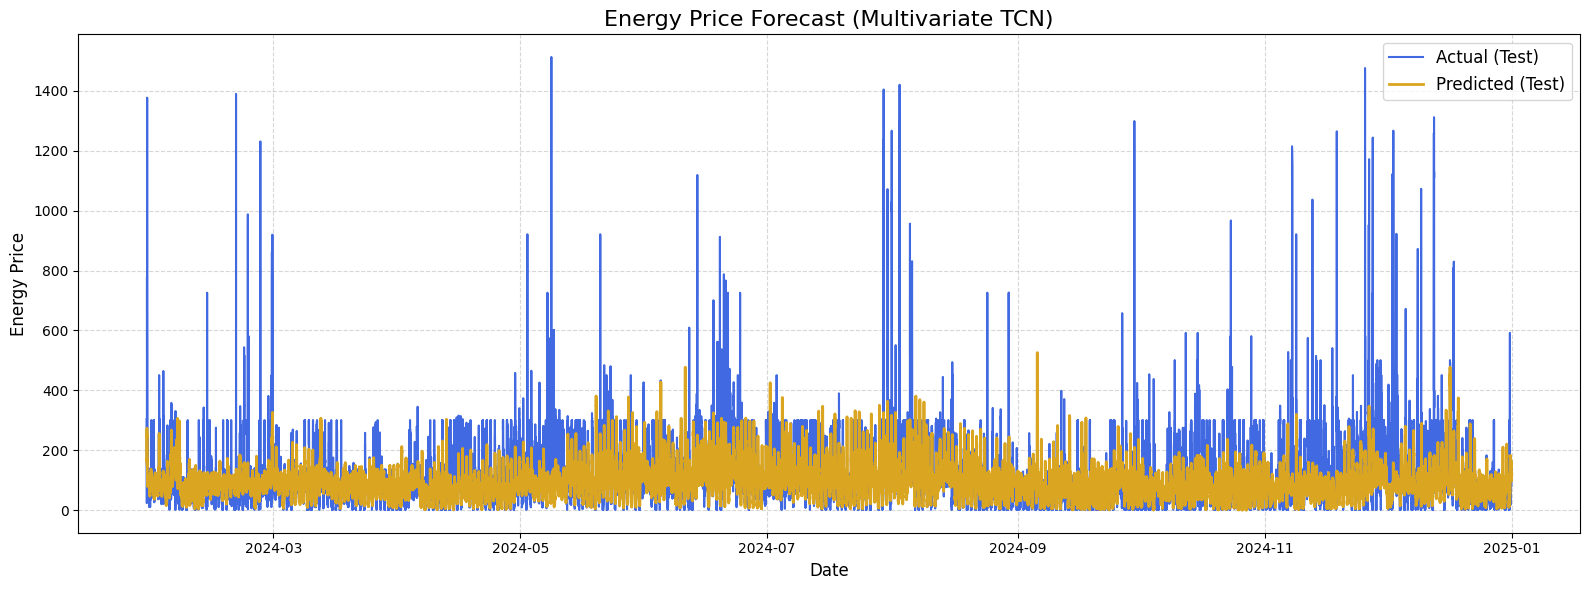


Evaluation Metrics:
Training Time (s) : 2164.86
Final Memory (MB) : 1321.93
RMSE              : 71.5440
MSE               : 5118.5390
MAE               : 44.0359
MAPE (%)          : 76.85
R² Score          : 0.2700
Adj. R²           : 0.2700


In [24]:
# Energy Price Forecasting (Multivariate)

# ─── Imports ─────────────────────────────────────────────────────────────────────
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import time
import psutil

# ─── Load Data ───────────────────────────────────────────────────────────────────
file_path = r"D:\Energy Price.csv"
df = pd.read_csv(file_path)

# ─── Preprocessing ───────────────────────────────────────────────────────────────
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna().sort_values('timestamp').reset_index(drop=True)

# Assume original energy price is already in log scale (e.g., log(Energy_Price))
df = df[df['Energy_Price'] >= 0].reset_index(drop=True)

# ─── Feature Setup ───────────────────────────────────────────────────────────────
target_col = 'Energy_Price'
input_cols = df.columns.difference(['timestamp', target_col])
data = df[input_cols.tolist() + [target_col]]

# ─── Normalize ───────────────────────────────────────────────────────────────────
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled, columns=data.columns)

# ─── Create Sequences ────────────────────────────────────────────────────────────
SEQ_LEN = 100
def create_sequences(data, target_col, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        seq_x = data.iloc[i:i+seq_len][input_cols].values
        seq_y = data.iloc[i+seq_len][target_col]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X_np, y_np = create_sequences(scaled_df, target_col, SEQ_LEN)
X = torch.tensor(X_np, dtype=torch.float32).permute(0, 2, 1)  # Shape: (B, C, T)
y = torch.tensor(y_np, dtype=torch.float32)

# ─── Train-Test Split ────────────────────────────────────────────────────────────
split_idx = int(0.7 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# ─── Define TCN Components ───────────────────────────────────────────────────────
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU()
        )
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=3):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            in_ch = input_size if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            dilation = 2 ** i
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation))
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size)
    def forward(self, x):
        y = self.network(x)
        return self.linear(y[:, :, -1])

# ─── Training ────────────────────────────────────────────────────────────────────
def get_final_memory_usage():
    return psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)

device = torch.device("cpu")  # Force CPU-only
print(f"Using device: {device}")

model = TCN(X.shape[1], 1, [16, 32, 32, 32]).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 50
BATCH_SIZE = 512
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)

start_time = time.time()
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb).squeeze()
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss / len(train_loader):.5f}")

train_time = round(time.time() - start_time, 2)
final_memory = round(get_final_memory_usage(), 2)

# ─── Prediction ──────────────────────────────────────────────────────────────────
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).cpu().numpy().squeeze()

# ─── Inverse Scaling and Log Correction ──────────────────────────────────────────
reconstruct = scaled_df.iloc[SEQ_LEN + split_idx:].copy().reset_index(drop=True)
reconstruct = reconstruct.iloc[:len(test_preds)]
reconstruct[target_col] = test_preds
inv_scaled = scaler.inverse_transform(reconstruct)

# Extract predicted and actual in original scale (apply exp because original data was log)
predicted_vals_log = inv_scaled[:, reconstruct.columns.get_loc(target_col)]
predicted_vals = np.exp(predicted_vals_log)

actual_vals_log = df[target_col].iloc[SEQ_LEN + split_idx:][:len(predicted_vals)].values
actual_vals = np.exp(actual_vals_log)

forecast_dates = df['timestamp'].iloc[SEQ_LEN + split_idx:][:len(predicted_vals)].values

# ─── Plot ────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(16, 6))
plt.plot(forecast_dates, actual_vals, label='Actual (Test)', color='royalblue', linewidth=1.5)
plt.plot(forecast_dates, predicted_vals, label='Predicted (Test)', color='goldenrod', linewidth=2)
plt.title('Energy Price Forecast (Multivariate TCN)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Energy Price', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# ─── Metrics ─────────────────────────────────────────────────────────────────────
mse = mean_squared_error(actual_vals, predicted_vals)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_vals, predicted_vals)
mape = np.mean(np.abs((actual_vals - predicted_vals) / actual_vals)) * 100
r2 = r2_score(actual_vals, predicted_vals)
n, k = len(actual_vals), X.shape[1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

print("\nEvaluation Metrics:")
print(f"Training Time (s) : {train_time}")
print(f"Final Memory (MB) : {final_memory}")
print(f"RMSE              : {rmse:.4f}")
print(f"MSE               : {mse:.4f}")
print(f"MAE               : {mae:.4f}")
print(f"MAPE (%)          : {mape:.2f}")
print(f"R² Score          : {r2:.4f}")
print(f"Adj. R²           : {adj_r2:.4f}")


Epoch 1/50, Loss: 0.00548
Epoch 2/50, Loss: 0.00029
Epoch 3/50, Loss: 0.00025
Epoch 4/50, Loss: 0.00017
Epoch 5/50, Loss: 0.00017
Epoch 6/50, Loss: 0.00018
Epoch 7/50, Loss: 0.00018
Epoch 8/50, Loss: 0.00018
Epoch 9/50, Loss: 0.00014
Epoch 10/50, Loss: 0.00012
Epoch 11/50, Loss: 0.00014
Epoch 12/50, Loss: 0.00011
Epoch 13/50, Loss: 0.00014
Epoch 14/50, Loss: 0.00013
Epoch 15/50, Loss: 0.00012
Epoch 16/50, Loss: 0.00013
Epoch 17/50, Loss: 0.00012
Epoch 18/50, Loss: 0.00009
Epoch 19/50, Loss: 0.00010
Epoch 20/50, Loss: 0.00011
Epoch 21/50, Loss: 0.00008
Epoch 22/50, Loss: 0.00012
Epoch 23/50, Loss: 0.00009
Epoch 24/50, Loss: 0.00010
Epoch 25/50, Loss: 0.00009
Epoch 26/50, Loss: 0.00010
Epoch 27/50, Loss: 0.00011
Epoch 28/50, Loss: 0.00010
Epoch 29/50, Loss: 0.00009
Epoch 30/50, Loss: 0.00011
Epoch 31/50, Loss: 0.00008
Epoch 32/50, Loss: 0.00012
Epoch 33/50, Loss: 0.00008
Epoch 34/50, Loss: 0.00009
Epoch 35/50, Loss: 0.00008
Epoch 36/50, Loss: 0.00010
Epoch 37/50, Loss: 0.00008
Epoch 38/5

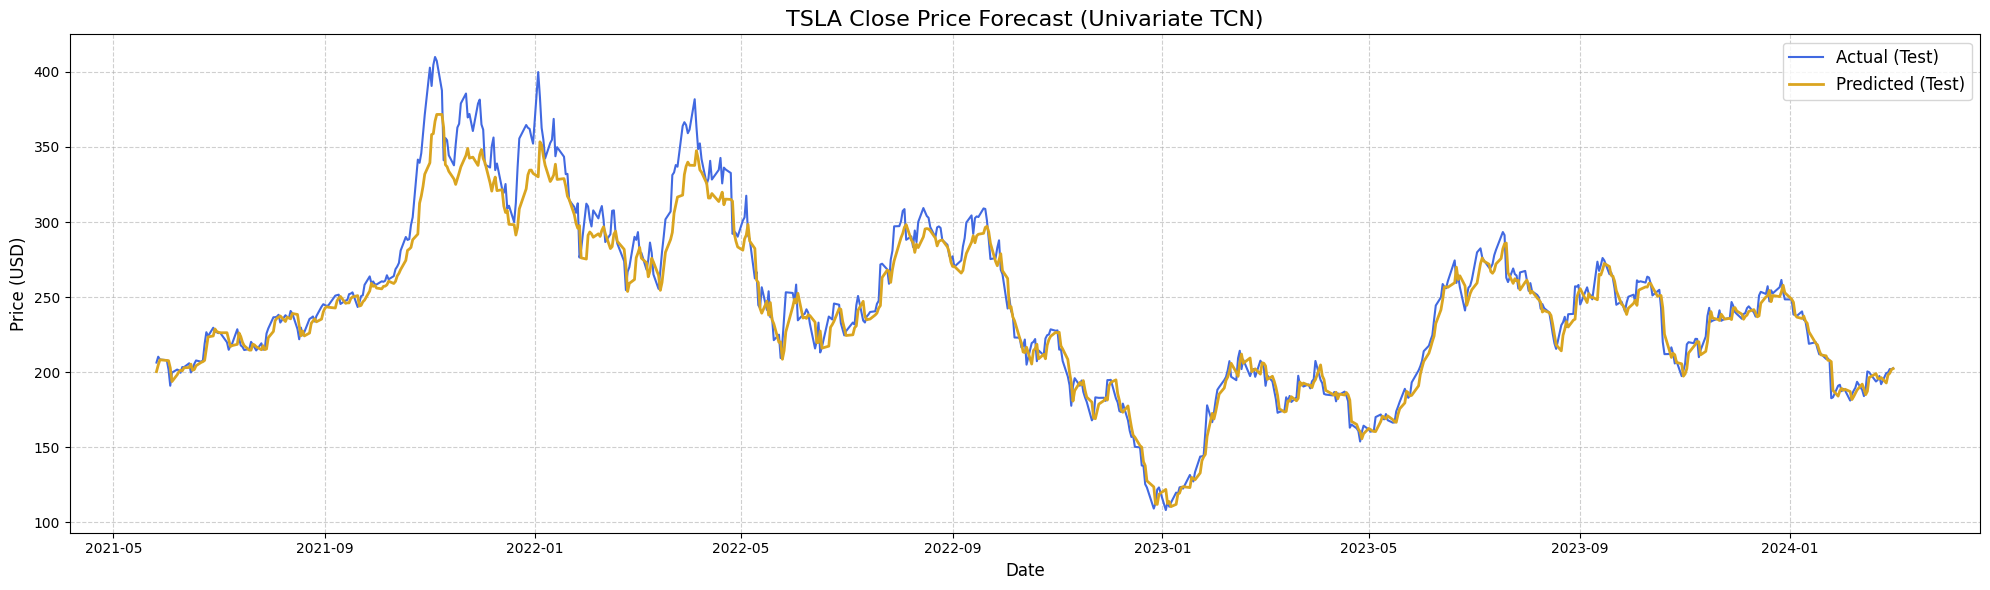


Evaluation Metrics:
Training Time (s) : 34.88
Peak Memory (MB)  : 1110.03
RMSE              : 12.6926
MSE               : 161.1009
MAE               : 8.6799
MAPE (%)          : 3.30
R² Score          : 0.9516
Adj. R²           : 0.9516


In [10]:
# Finance Forecasting (Univariate TCN)

# ─── Imports ─────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import time
import psutil
import os

# ─── Load Dataset ────────────────────────────────────────────────────────────────
file_path = r"D:\Finance.csv"
df = pd.read_csv(file_path)

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna().sort_values('Date').reset_index(drop=True)
df = df[df['Close_TSLA'] >= 0].reset_index(drop=True)

target_col = 'Close_TSLA'
scaler = MinMaxScaler()
df['ScaledTarget'] = scaler.fit_transform(df[[target_col]])

# ─── Create Sequences ────────────────────────────────────────────────────────────
SEQ_LEN = 60
def create_sequences(series, seq_len):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i+seq_len])
        y.append(series[i+seq_len])
    return np.array(X), np.array(y)

X_np, y_np = create_sequences(df['ScaledTarget'].values, SEQ_LEN)
X = torch.tensor(X_np, dtype=torch.float32).unsqueeze(1)  # Shape: (B, C, T)
y = torch.tensor(y_np, dtype=torch.float32)

# ─── Train-Test Split ────────────────────────────────────────────────────────────
split_idx = int(0.7 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# ─── Define TCN Components ───────────────────────────────────────────────────────
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU()
        )
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=3):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            in_ch = input_size if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            dilation = 2 ** i
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation))
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size)
    def forward(self, x):
        y = self.network(x)
        return self.linear(y[:, :, -1])

# ─── Training ────────────────────────────────────────────────────────────────────
def get_memory_usage():
    return psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)

device = torch.device("cpu")
model = TCN(1, 1, [16, 32, 32, 32]).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 50
BATCH_SIZE = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)

start_time = time.time()
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb).squeeze()
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss / len(train_loader):.5f}")

train_time = round(time.time() - start_time, 2)
peak_mem = round(get_memory_usage(), 2)

# ─── Predict on Test Set ─────────────────────────────────────────────────────────
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).cpu().numpy().squeeze()

# ─── Inverse Scale Predictions ───────────────────────────────────────────────────
predicted_vals = scaler.inverse_transform(test_preds.reshape(-1, 1)).flatten()
actual_vals = df[target_col].iloc[SEQ_LEN + split_idx:][:len(predicted_vals)].values
forecast_dates = df['Date'].iloc[SEQ_LEN + split_idx:][:len(predicted_vals)].values

# ─── Plot Forecast (Test Only) ───────────────────────────────────────────────────
plt.figure(figsize=(20, 6))
plt.plot(forecast_dates, actual_vals, label='Actual (Test)', color='royalblue', linewidth=1.5)
plt.plot(forecast_dates, predicted_vals, label='Predicted (Test)', color='goldenrod', linewidth=2)
plt.title('TSLA Close Price Forecast (Univariate TCN)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# ─── Metrics ─────────────────────────────────────────────────────────────────────
mse = mean_squared_error(actual_vals, predicted_vals)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_vals, predicted_vals)
mape = np.mean(np.abs((actual_vals - predicted_vals) / actual_vals)) * 100
r2 = r2_score(actual_vals, predicted_vals)
n, k = len(actual_vals), X.shape[1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

print("\nEvaluation Metrics:")
print(f"Training Time (s) : {train_time}")
print(f"Peak Memory (MB)  : {peak_mem}")
print(f"RMSE              : {rmse:.4f}")
print(f"MSE               : {mse:.4f}")
print(f"MAE               : {mae:.4f}")
print(f"MAPE (%)          : {mape:.2f}")
print(f"R² Score          : {r2:.4f}")
print(f"Adj. R²           : {adj_r2:.4f}")


Using device: cpu
Epoch 1/50, Loss: 0.00749
Epoch 2/50, Loss: 0.00051
Epoch 3/50, Loss: 0.00037
Epoch 4/50, Loss: 0.00030
Epoch 5/50, Loss: 0.00030
Epoch 6/50, Loss: 0.00025
Epoch 7/50, Loss: 0.00020
Epoch 8/50, Loss: 0.00020
Epoch 9/50, Loss: 0.00020
Epoch 10/50, Loss: 0.00016
Epoch 11/50, Loss: 0.00018
Epoch 12/50, Loss: 0.00014
Epoch 13/50, Loss: 0.00015
Epoch 14/50, Loss: 0.00015
Epoch 15/50, Loss: 0.00015
Epoch 16/50, Loss: 0.00012
Epoch 17/50, Loss: 0.00012
Epoch 18/50, Loss: 0.00011
Epoch 19/50, Loss: 0.00013
Epoch 20/50, Loss: 0.00011
Epoch 21/50, Loss: 0.00013
Epoch 22/50, Loss: 0.00012
Epoch 23/50, Loss: 0.00011
Epoch 24/50, Loss: 0.00009
Epoch 25/50, Loss: 0.00010
Epoch 26/50, Loss: 0.00009
Epoch 27/50, Loss: 0.00009
Epoch 28/50, Loss: 0.00010
Epoch 29/50, Loss: 0.00010
Epoch 30/50, Loss: 0.00009
Epoch 31/50, Loss: 0.00006
Epoch 32/50, Loss: 0.00008
Epoch 33/50, Loss: 0.00007
Epoch 34/50, Loss: 0.00008
Epoch 35/50, Loss: 0.00015
Epoch 36/50, Loss: 0.00008
Epoch 37/50, Loss: 

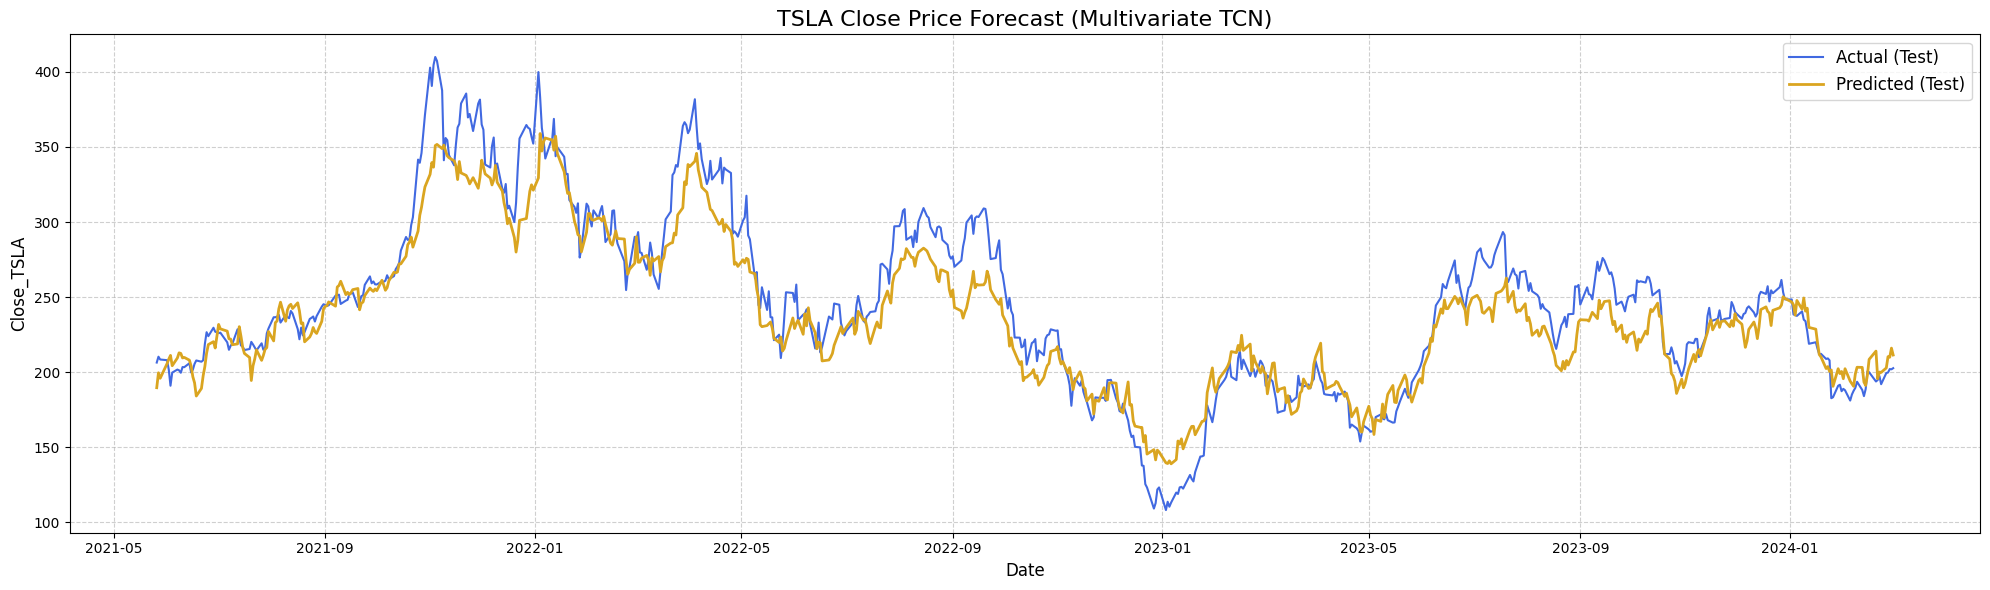


Evaluation Metrics:
Training Time (s) : 34.75
Final Memory (MB) : 1166.13
RMSE              : 20.3798
MSE               : 415.3346
MAE               : 15.5883
MAPE (%)          : 6.36
R² Score          : 0.8753
Adj. R²           : 0.8629


In [12]:
# Finance Forecasting (multivariate)

# ─── Imports ─────────────────────────────────────────────────────────────────────
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import time
import psutil

# ─── Load Dataset ────────────────────────────────────────────────────────────────
file_path = r"D:\Finance.csv"
df = pd.read_csv(file_path)

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna().sort_values('Date').reset_index(drop=True)
df = df[df['Close_TSLA'] >= 0].reset_index(drop=True)

# ─── Set Target and Features ─────────────────────────────────────────────────────
target_col = 'Close_TSLA'
exclude_cols = ['Date', target_col, 'Volume']
input_cols = df.columns.difference(exclude_cols)

# ─── Normalize ───────────────────────────────────────────────────────────────────
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[input_cols.tolist() + [target_col]])
scaled_df = pd.DataFrame(scaled, columns=input_cols.tolist() + [target_col])

# ─── Create Sequences ────────────────────────────────────────────────────────────
SEQ_LEN = 60
def create_sequences(data, target_col, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        seq_x = data.iloc[i:i+seq_len][input_cols].values
        seq_y = data.iloc[i+seq_len][target_col]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X_np, y_np = create_sequences(scaled_df, target_col, SEQ_LEN)
X = torch.tensor(X_np, dtype=torch.float32).permute(0, 2, 1)  # Shape: (Batch, Channels, Time)
y = torch.tensor(y_np, dtype=torch.float32)

# ─── Train-Test Split ────────────────────────────────────────────────────────────
split_idx = int(0.7 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# ─── TCN Definition ──────────────────────────────────────────────────────────────
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU()
        )
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=3):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            in_ch = input_size if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            dilation = 2 ** i
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation))
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size)
    def forward(self, x):
        y = self.network(x)
        return self.linear(y[:, :, -1])

# ─── Training ────────────────────────────────────────────────────────────────────
def get_final_memory_usage():
    return psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)

device = torch.device("cpu")  # Enforce CPU-only
print(f"Using device: {device}")

model = TCN(X.shape[1], 1, [16, 32, 32, 32]).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 50
BATCH_SIZE = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)

start_time = time.time()
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb).squeeze()
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss / len(train_loader):.5f}")

train_time = round(time.time() - start_time, 2)
final_mem = round(get_final_memory_usage(), 2)

# ─── Prediction ──────────────────────────────────────────────────────────────────
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).cpu().numpy().squeeze()

# ─── Inverse Scaling ─────────────────────────────────────────────────────────────
reconstruct = scaled_df.iloc[SEQ_LEN + split_idx:].copy().reset_index(drop=True)
reconstruct = reconstruct.iloc[:len(test_preds)].copy()
reconstruct[target_col] = test_preds
inv_scaled = scaler.inverse_transform(reconstruct)
predicted_vals = inv_scaled[:, reconstruct.columns.get_loc(target_col)]

actual_vals = df[target_col].iloc[SEQ_LEN + split_idx:][:len(predicted_vals)].values
forecast_dates = df['Date'].iloc[SEQ_LEN + split_idx:][:len(predicted_vals)].values

# ─── Plot Test Forecast ──────────────────────────────────────────────────────────
plt.figure(figsize=(20, 6))
plt.plot(forecast_dates, actual_vals, label='Actual (Test)', color='royalblue', linewidth=1.5)
plt.plot(forecast_dates, predicted_vals, label='Predicted (Test)', color='goldenrod', linewidth=2)
plt.title('TSLA Close Price Forecast (Multivariate TCN)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close_TSLA', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# ─── Evaluation Metrics ──────────────────────────────────────────────────────────
mse = mean_squared_error(actual_vals, predicted_vals)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_vals, predicted_vals)
mape = np.mean(np.abs((actual_vals - predicted_vals) / actual_vals)) * 100
r2 = r2_score(actual_vals, predicted_vals)
n, k = len(actual_vals), X.shape[1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

print("\nEvaluation Metrics:")
print(f"Training Time (s) : {train_time}")
print(f"Final Memory (MB) : {final_mem}")
print(f"RMSE              : {rmse:.4f}")
print(f"MSE               : {mse:.4f}")
print(f"MAE               : {mae:.4f}")
print(f"MAPE (%)          : {mape:.2f}")
print(f"R² Score          : {r2:.4f}")
print(f"Adj. R²           : {adj_r2:.4f}")


Using device: cpu
Epoch   1/100 - Loss: 0.046754
Epoch   2/100 - Loss: 0.016678
Epoch   3/100 - Loss: 0.014476
Epoch   4/100 - Loss: 0.013602
Epoch   5/100 - Loss: 0.013122
Epoch   6/100 - Loss: 0.012429
Epoch   7/100 - Loss: 0.012402
Epoch   8/100 - Loss: 0.012534
Epoch   9/100 - Loss: 0.012903
Epoch  10/100 - Loss: 0.012393
Epoch  11/100 - Loss: 0.012137
Epoch  12/100 - Loss: 0.012456
Epoch  13/100 - Loss: 0.012371
Epoch  14/100 - Loss: 0.011822
Epoch  15/100 - Loss: 0.012475
Epoch  16/100 - Loss: 0.012065
Epoch  17/100 - Loss: 0.012102
Epoch  18/100 - Loss: 0.011840
Epoch  19/100 - Loss: 0.012183
Epoch  20/100 - Loss: 0.012112
Epoch  21/100 - Loss: 0.012114
Epoch  22/100 - Loss: 0.011790
Epoch  23/100 - Loss: 0.012028
Epoch  24/100 - Loss: 0.012101
Epoch  25/100 - Loss: 0.011858
Epoch  26/100 - Loss: 0.012394
Epoch  27/100 - Loss: 0.012342
Epoch  28/100 - Loss: 0.012016
Epoch  29/100 - Loss: 0.011885
Epoch  30/100 - Loss: 0.011749
Epoch  31/100 - Loss: 0.011736
Epoch  32/100 - Loss:

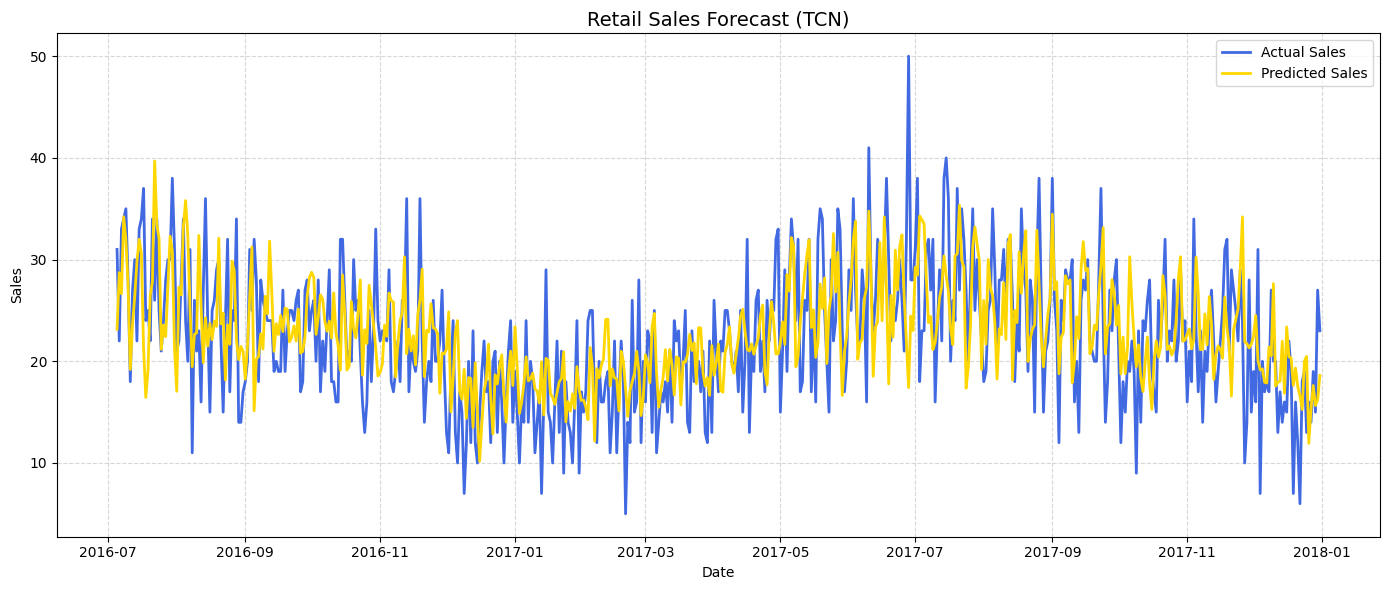


Evaluation Metrics:
Training Time (s) : 75.05
Final Memory (MB) : 1114.66
RMSE              : 5.9592
MSE               : 35.5116
MAE               : 4.7664
MAPE (%)          : 24.90
R² Score          : 0.2202
Adj. R²           : 0.2188


In [19]:
# Retail Forecasting

# ─── Imports ─────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import time
import psutil

# ─── Load & Prepare Dataset ──────────────────────────────────────────────────────
file_path = r"D:\Retail.csv"
df = pd.read_csv(file_path)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df[['date', 'sales']].dropna()
df = df[df['sales'] >= 0].sort_values('date').reset_index(drop=True)

# ─── Normalize ───────────────────────────────────────────────────────────────────
scaler = MinMaxScaler()
df['ScaledSales'] = scaler.fit_transform(df[['sales']])

# ─── Create Sequences ────────────────────────────────────────────────────────────
SEQ_LEN = 12
def create_sequences(series, seq_len):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i+seq_len])
        y.append(series[i+seq_len])
    return np.array(X), np.array(y)

X_np, y_np = create_sequences(df['ScaledSales'].values, SEQ_LEN)
X = torch.tensor(X_np, dtype=torch.float32).unsqueeze(1)  # Shape: (Batch, 1, Seq)
y = torch.tensor(y_np, dtype=torch.float32)

# ─── Train-Test Split ────────────────────────────────────────────────────────────
split_idx = int(0.7 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# ─── TCN Model Definition ────────────────────────────────────────────────────────
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU()
        )
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()
    def forward(self, x):
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(self.net(x) + res)

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=3):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            in_ch = input_size if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            dilation = 2 ** i
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation))
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size)
    def forward(self, x):
        y = self.network(x)
        return self.linear(y[:, :, -1])

# ─── Train Model ─────────────────────────────────────────────────────────────────
device = torch.device("cpu")
print(f"Using device: {device}")

model = TCN(input_size=1, output_size=1, num_channels=[16, 32, 32, 32]).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 100
BATCH_SIZE = 16
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)

start_time = time.time()
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb).squeeze()
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1:3d}/{EPOCHS} - Loss: {total_loss/len(train_loader):.6f}")
train_time = round(time.time() - start_time, 2)
final_mem = round(psutil.Process().memory_info().rss / 1024 / 1024, 2)

# ─── Predict ─────────────────────────────────────────────────────────────────────
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).cpu().numpy().squeeze()

# ─── Inverse Scale and Plot ──────────────────────────────────────────────────────
predicted_vals = scaler.inverse_transform(test_preds.reshape(-1, 1))[:, 0]
actual_vals = df['sales'].iloc[SEQ_LEN + split_idx:][:len(predicted_vals)].values
forecast_dates = df['date'].iloc[SEQ_LEN + split_idx:][:len(predicted_vals)].values

plt.figure(figsize=(14, 6))
plt.plot(forecast_dates, actual_vals, label='Actual Sales', color='royalblue', linewidth=2)
plt.plot(forecast_dates, predicted_vals, label='Predicted Sales', color='gold', linewidth=2)
plt.title('Retail Sales Forecast (TCN)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ─── Metrics ─────────────────────────────────────────────────────────────────────
mse = mean_squared_error(actual_vals, predicted_vals)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_vals, predicted_vals)
mape = np.mean(np.abs((actual_vals - predicted_vals) / actual_vals)) * 100
r2 = r2_score(actual_vals, predicted_vals)

n = len(actual_vals)
k = 1
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

print("\nEvaluation Metrics:")
print(f"Training Time (s) : {train_time}")
print(f"Final Memory (MB) : {final_mem}")
print(f"RMSE              : {rmse:.4f}")
print(f"MSE               : {mse:.4f}")
print(f"MAE               : {mae:.4f}")
print(f"MAPE (%)          : {mape:.2f}")
print(f"R² Score          : {r2:.4f}")
print(f"Adj. R²           : {adj_r2:.4f}")

Using device: cpu
Epoch 1/100, Loss: 0.08702
Epoch 2/100, Loss: 0.01886
Epoch 3/100, Loss: 0.00776
Epoch 4/100, Loss: 0.00661
Epoch 5/100, Loss: 0.00729
Epoch 6/100, Loss: 0.00590
Epoch 7/100, Loss: 0.00555
Epoch 8/100, Loss: 0.00620
Epoch 9/100, Loss: 0.00509
Epoch 10/100, Loss: 0.00536
Epoch 11/100, Loss: 0.00524
Epoch 12/100, Loss: 0.00418
Epoch 13/100, Loss: 0.00444
Epoch 14/100, Loss: 0.00401
Epoch 15/100, Loss: 0.00399
Epoch 16/100, Loss: 0.00391
Epoch 17/100, Loss: 0.00401
Epoch 18/100, Loss: 0.00454
Epoch 19/100, Loss: 0.00429
Epoch 20/100, Loss: 0.00379
Epoch 21/100, Loss: 0.00347
Epoch 22/100, Loss: 0.00354
Epoch 23/100, Loss: 0.00367
Epoch 24/100, Loss: 0.00380
Epoch 25/100, Loss: 0.00369
Epoch 26/100, Loss: 0.00332
Epoch 27/100, Loss: 0.00386
Epoch 28/100, Loss: 0.00384
Epoch 29/100, Loss: 0.00360
Epoch 30/100, Loss: 0.00360
Epoch 31/100, Loss: 0.00371
Epoch 32/100, Loss: 0.00377
Epoch 33/100, Loss: 0.00361
Epoch 34/100, Loss: 0.00323
Epoch 35/100, Loss: 0.00382
Epoch 36/10

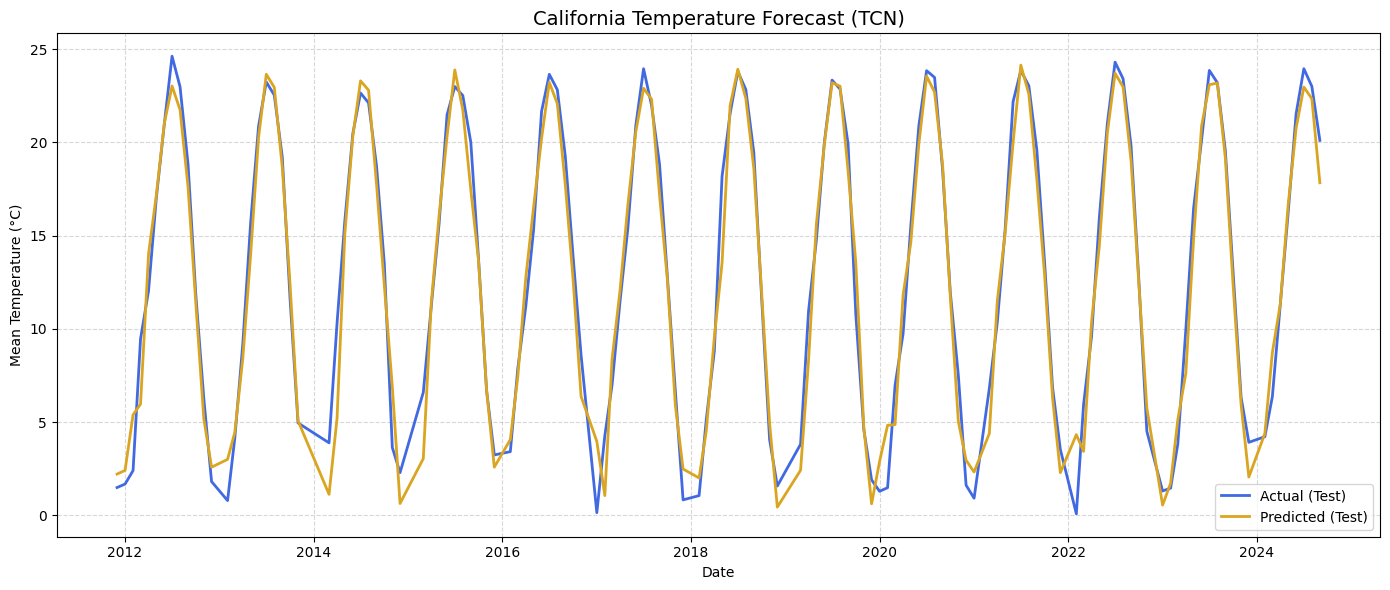


Evaluation Metrics:
Training Time (s) : 20.18
Final Memory (MB) : 1118.64
RMSE              : 1.5376
MSE               : 2.3642
MAE               : 1.1639
MAPE (%)          : 81.64
R² Score          : 0.9619
Adj. R²           : 0.9616


In [20]:
# Temperature Forecasting

# ─── Imports ─────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import time
import psutil

# ─── Load Data ───────────────────────────────────────────────────────────────────
file_path = r"D:\Temperature Data of California.csv"
df = pd.read_csv(file_path)

# ─── Preprocessing ───────────────────────────────────────────────────────────────
df['Time'] = pd.to_datetime(df['TIME'], format='%Y-%m', errors='coerce')
df = df[['Time', 'Mean_Temperature']].dropna()
df = df[df['Mean_Temperature'] >= 0].sort_values('Time').reset_index(drop=True)

scaler = MinMaxScaler()
df['ScaledTemp'] = scaler.fit_transform(df[['Mean_Temperature']])

# ─── Create Sequences ────────────────────────────────────────────────────────────
SEQ_LEN = 12
def create_sequences(series, seq_len):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i+seq_len])
        y.append(series[i+seq_len])
    return np.array(X), np.array(y)

X_np, y_np = create_sequences(df['ScaledTemp'].values, SEQ_LEN)
X = torch.tensor(X_np, dtype=torch.float32).unsqueeze(1)  # Shape: (Batch, 1, Time)
y = torch.tensor(y_np, dtype=torch.float32)

# ─── Train-Test Split ────────────────────────────────────────────────────────────
split_idx = int(0.7 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# ─── Define TCN ──────────────────────────────────────────────────────────────────
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU()
        )
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=3):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            in_ch = input_size if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            dilation = 2 ** i
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation))
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size)
    def forward(self, x):
        y = self.network(x)
        return self.linear(y[:, :, -1])

# ─── Train Model ─────────────────────────────────────────────────────────────────
device = torch.device("cpu")
print(f"Using device: {device}")

model = TCN(1, 1, [16, 32, 32, 32]).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 100
BATCH_SIZE = 16
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)

start_time = time.time()
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb).squeeze()
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.5f}")
train_time = round(time.time() - start_time, 2)
final_mem = round(psutil.Process().memory_info().rss / 1024 / 1024, 2)

# ─── Predict ─────────────────────────────────────────────────────────────────────
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).cpu().numpy().squeeze()

# ─── Inverse Scale ───────────────────────────────────────────────────────────────
predicted_vals = scaler.inverse_transform(test_preds.reshape(-1, 1)).flatten()
actual_vals = df['Mean_Temperature'].iloc[SEQ_LEN + split_idx:][:len(predicted_vals)].values
forecast_dates = df['Time'].iloc[SEQ_LEN + split_idx:][:len(predicted_vals)].values

# ─── Plot ────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(14, 6))
plt.plot(forecast_dates, actual_vals, label='Actual (Test)', color='royalblue', linewidth=2)
plt.plot(forecast_dates, predicted_vals, label='Predicted (Test)', color='goldenrod', linewidth=2)
plt.title('California Temperature Forecast (TCN)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ─── Evaluation ──────────────────────────────────────────────────────────────────
mse = mean_squared_error(actual_vals, predicted_vals)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_vals, predicted_vals)
mape = np.mean(np.abs((actual_vals - predicted_vals) / actual_vals)) * 100
r2 = r2_score(actual_vals, predicted_vals)
adj_r2 = 1 - (1 - r2) * (len(actual_vals) - 1) / (len(actual_vals) - 2)

print("\nEvaluation Metrics:")
print(f"Training Time (s) : {train_time}")
print(f"Final Memory (MB) : {final_mem}")
print(f"RMSE              : {rmse:.4f}")
print(f"MSE               : {mse:.4f}")
print(f"MAE               : {mae:.4f}")
print(f"MAPE (%)          : {mape:.2f}")
print(f"R² Score          : {r2:.4f}")
print(f"Adj. R²           : {adj_r2:.4f}")


Using device: cpu
Epoch 1/100, Loss: 0.28986
Epoch 2/100, Loss: 0.02279
Epoch 3/100, Loss: 0.01347
Epoch 4/100, Loss: 0.00859
Epoch 5/100, Loss: 0.00706
Epoch 6/100, Loss: 0.00622
Epoch 7/100, Loss: 0.00589
Epoch 8/100, Loss: 0.00531
Epoch 9/100, Loss: 0.00499
Epoch 10/100, Loss: 0.00431
Epoch 11/100, Loss: 0.00386
Epoch 12/100, Loss: 0.00376
Epoch 13/100, Loss: 0.00316
Epoch 14/100, Loss: 0.00283
Epoch 15/100, Loss: 0.00263
Epoch 16/100, Loss: 0.00258
Epoch 17/100, Loss: 0.00244
Epoch 18/100, Loss: 0.00243
Epoch 19/100, Loss: 0.00245
Epoch 20/100, Loss: 0.00237
Epoch 21/100, Loss: 0.00248
Epoch 22/100, Loss: 0.00306
Epoch 23/100, Loss: 0.00269
Epoch 24/100, Loss: 0.00251
Epoch 25/100, Loss: 0.00250
Epoch 26/100, Loss: 0.00234
Epoch 27/100, Loss: 0.00252
Epoch 28/100, Loss: 0.00302
Epoch 29/100, Loss: 0.00247
Epoch 30/100, Loss: 0.00242
Epoch 31/100, Loss: 0.00281
Epoch 32/100, Loss: 0.00255
Epoch 33/100, Loss: 0.00240
Epoch 34/100, Loss: 0.00271
Epoch 35/100, Loss: 0.00265
Epoch 36/10

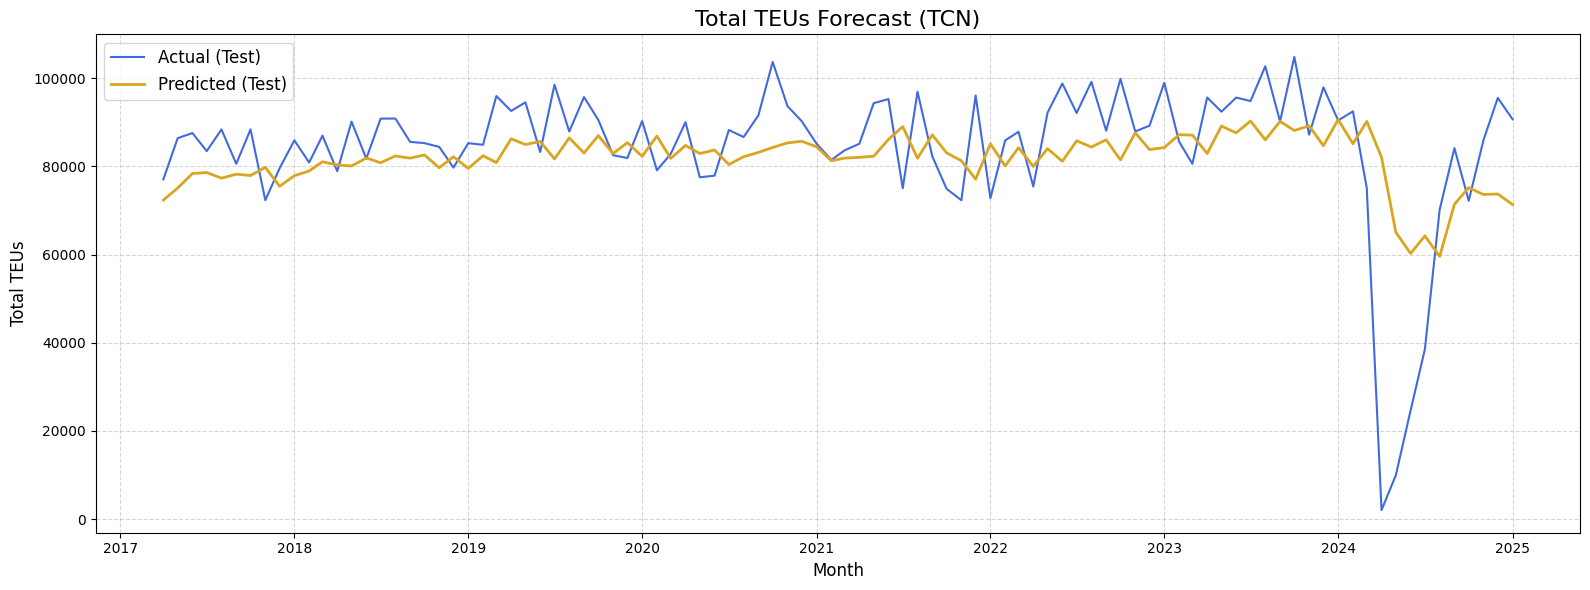


Evaluation Metrics:
Training Time (s) : 13.1
Final Memory (MB) : 1124.33
RMSE              : 14335.76
MSE               : 205513952.00
MAE               : 9428.77
MAPE (%)          : 57.84
R² Score          : 0.2008
Adj. R²           : 0.1922


In [22]:
# Transportation Forecasting

# ─── Imports ─────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import time
import psutil
import os

# ─── Load Dataset ────────────────────────────────────────────────────────────────
file_path = r"D:\Transportation.csv"
df = pd.read_csv(file_path)

# ─── Preprocessing ───────────────────────────────────────────────────────────────
df['Month'] = pd.to_datetime(df['Month'], format='%b-%y', errors='coerce')
df = df[['Month', 'Total TEUs']].dropna()
df = df[df['Total TEUs'] >= 0].sort_values('Month').reset_index(drop=True)

scaler = MinMaxScaler()
df['ScaledTarget'] = scaler.fit_transform(df[['Total TEUs']])

# ─── Create Sequences ────────────────────────────────────────────────────────────
SEQ_LEN = 12
def create_sequences(series, seq_len):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i+seq_len])
        y.append(series[i+seq_len])
    return np.array(X), np.array(y)

X_np, y_np = create_sequences(df['ScaledTarget'].values, SEQ_LEN)
X = torch.tensor(X_np, dtype=torch.float32).unsqueeze(1)  # (B, 1, T)
y = torch.tensor(y_np, dtype=torch.float32)

# ─── Train-Test Split ────────────────────────────────────────────────────────────
split_idx = int(0.7 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# ─── Define TCN ──────────────────────────────────────────────────────────────────
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU()
        )
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=3):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            in_ch = input_size if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            dilation = 2 ** i
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation))
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size)
    def forward(self, x):
        y = self.network(x)
        return self.linear(y[:, :, -1])

# ─── Train Model ─────────────────────────────────────────────────────────────────
def get_memory_usage():
    return round(psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024, 2)

device = torch.device("cpu")
print(f"Using device: {device}")

model = TCN(1, 1, [16, 32, 32, 32]).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 100
BATCH_SIZE = 16
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)

start_time = time.time()
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb).squeeze()
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss / len(train_loader):.5f}")
train_time = round(time.time() - start_time, 2)
final_mem = get_memory_usage()

# ─── Prediction and Inverse Scaling ──────────────────────────────────────────────
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).cpu().numpy().squeeze()

predicted_vals = scaler.inverse_transform(test_preds.reshape(-1, 1)).flatten()
actual_vals = df['Total TEUs'].iloc[SEQ_LEN + split_idx:][:len(predicted_vals)].values
forecast_months = df['Month'].iloc[SEQ_LEN + split_idx:][:len(predicted_vals)].values

# ─── Plot ────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(16, 6))
plt.plot(forecast_months, actual_vals, label='Actual (Test)', color='royalblue', linewidth=1.5)
plt.plot(forecast_months, predicted_vals, label='Predicted (Test)', color='goldenrod', linewidth=2)
plt.title('Total TEUs Forecast (TCN)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total TEUs', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# ─── Evaluation ──────────────────────────────────────────────────────────────────
mse = mean_squared_error(actual_vals, predicted_vals)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_vals, predicted_vals)
mape = np.mean(np.abs((actual_vals - predicted_vals) / actual_vals)) * 100
r2 = r2_score(actual_vals, predicted_vals)
n = len(actual_vals)
p = 1
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("\nEvaluation Metrics:")
print(f"Training Time (s) : {train_time}")
print(f"Final Memory (MB) : {final_mem}")
print(f"RMSE              : {rmse:.2f}")
print(f"MSE               : {mse:.2f}")
print(f"MAE               : {mae:.2f}")
print(f"MAPE (%)          : {mape:.2f}")
print(f"R² Score          : {r2:.4f}")
print(f"Adj. R²           : {adj_r2:.4f}")
